In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import os
import decimal

1000
Average total QPD signal is 2.5303926690000003
slope: 0.3042202509288856 +- 0.004369311302749165
y-int: -1.669040180383374 +- 0.02379091496707001


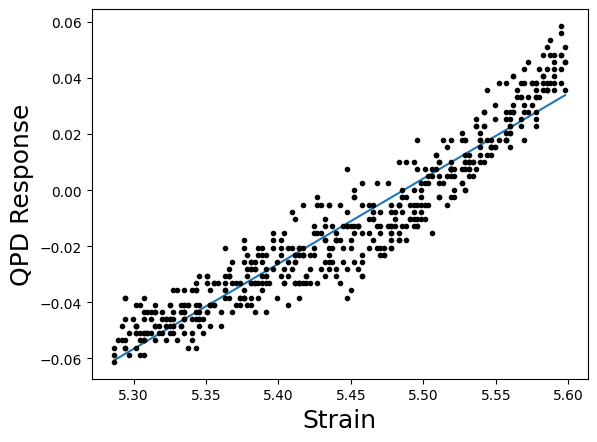

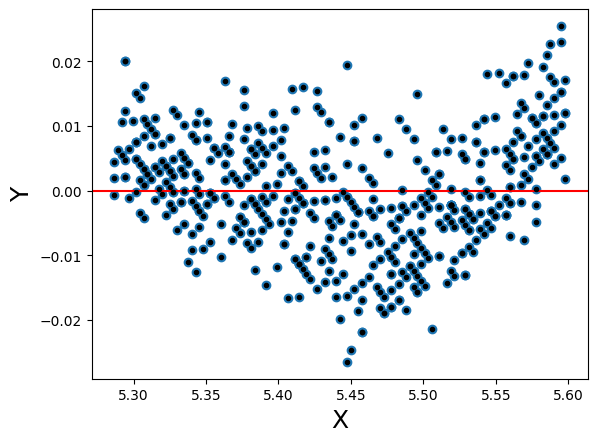

In [4]:
data_file = 'calibrate_main_equi2.csv'

xdata, ydata, total  = np.loadtxt(
        data_file,                                # file to read
        delimiter = ',',                          # specify delimiting character
        skiprows = 1,                             # rows to skip for header
        usecols = (1, 2, 3),                         # which columns to use
        unpack = True)                            # indicates that our data sets are in columns, not rows

print(len(total))
print("Average total QPD signal is", np.sum(total)/len(total))

X, Y = [], []
for i in range(len(xdata)):
        if xdata[i] < 5.6:
                X.append( xdata[i] )
                Y.append( ydata[i] )
X = np.array(X)
Y = np.array(Y)

def func(x,m,b):                                # Define your fitting function

        return m*x+b

initialguess = [1,1]                     # initial guess for the parameters of the function func

fit, covariance = optimize.curve_fit(             # call to the fitting routine curve_fit
        func,                                     # function to fit
        X,                                    # data for independant variable
        Y,                                    # data for dependant variable
        initialguess)                             # initial guess of fit parameter

print("slope:",fit[0],"+-",np.sqrt(covariance[0][0]))     #print value and one std error of the first fit parameter
print("y-int:",fit[1],"+-",np.sqrt(covariance[1][1]))     #print value and one std error of the second fit parameter

##########
# Plotting data and fit
##########

xdatafit=np.linspace(min(X), max(X), 100)    # make lots of xdata for a smooth curve
func_plot=func(xdatafit,*fit)                # create discrete data set from fitting function

plt.clf()                                    # clear plot figure
plt.plot(xdatafit, func_plot)                # plot the fit function
plt.errorbar(X, Y, fmt='k.')                 # plot data with error bars, define format of plot (k=black)
#plt.title('Best Fit Linear Equation')       # plot title
plt.xlabel('Strain',fontsize = 18)           # label x axis
plt.ylabel('QPD Response',fontsize = 18)     # label y axis
#plt.xlim(np.min(xdata),np.max(xdata))       # choose limits of x or y axis
#plt.ylim(np.min(ydata),np.max(ydata))       # choose limits of x or y axis
#plt.savefig('./dataWithFit.pdf',dpi=100,bbox_inches='tight')
plt.show()                                   # show plot

##########
# Plotting residuals
##########

func_model=func(X,*fit)              # create discrete data set from fitting function
residual = (Y-func_model)            # create array of residual data

plt.clf()
plt.errorbar(X, residual, fmt='k.')
plt.plot(X, residual, 'o')
plt.axhline(y=0.0, color='r', linestyle='-')
#plt.title('Residual')
plt.xlabel('X',fontsize = 18)
plt.ylabel('Y',fontsize = 18)
#plt.savefig('./Residual.pdf',dpi=100,bbox_inches='tight')
plt.show()

In [3]:
# Define functions for calculating k and k_unc in terms of b, m, and dif

boltzmann =  1.380649e-23
T = 298.1                        # SATP in K
m, m_unc = 0.304, 0.004
b, b_unc = 1.67, 0.02

def find_smallest_decimal_place(number):    # function for quickly getting the error on each x_dif, y_dif

    decimal_place = 1
    while number * decimal_place != int(number * decimal_place):
        decimal_place *= 10

    return 1 / decimal_place

def strain(dif):
    return (dif-b)/m

def stiff (dif):                    # calculate stiffness as a function of dif
    return boltzmann * T * ( m / (dif-b) )**2

def stiff_err (dif, dif_unc):       # uncertainty in stiffness in terms of fit params, dif, and errors
    return 2 * boltzmann * T * ( m / (dif-b) )**3 * ( 1/m * (dif_unc+b_unc) + m_unc * ( (dif-b) / m**2  ) )

In [65]:
# Need to read in all the data now, and normalize it:

folder_path = './Equi/'
data_file = 'equi_249.7'

xdata, ydata, total  = np.loadtxt(
    folder_path + data_file,                                # file to read
    delimiter = ',',                          # specify delimiting character
    skiprows = 1,                             # rows to skip for header
    usecols = (1, 2, 3),                         # which columns to use
    unpack = True)                            # indicates that our data sets are in columns, not rows.

x_dif, y_dif = xdata, ydata
dif, x_strain = [], []

for i in range(len(x_dif)):
    dif.append( np.sqrt(x_dif[i]**2 + y_dif[i]**2) )
    x_strain.append( strain(x_dif[i]) )

In [66]:
# Get the uncertainties on x_dif, y_dif & dif

x_dif_err, y_dif_err, dif_err = [], [], []

for i in range(len(x_dif)):
    x_dif_err.append( find_smallest_decimal_place(xdata[i]) )
    y_dif_err.append( find_smallest_decimal_place(ydata[i]) )
    dif_err.append( 1/np.sqrt((x_dif[i]**2)+(y_dif[i]**2)) * ((x_dif[i] * x_dif_err[i]) + (y_dif[i] * y_dif_err[i])) )
print(len(dif_err))

1000


In [67]:
# get trap stiffness k and k_err

k_data, k_err = [], []

for i in range(len(dif)):
    k_data.append( stiff(dif[i]) )
    k_err.append( stiff_err(dif[i], dif_err[i]) )

for i in range(len(k_data)):
    if k_data[i] < 0:
        print('alert')

In [68]:
# Calculate weights for each measurement of k

k_err_squared, weights = [], []
sum = 0
for i in range(len(k_err)):
    sum = sum + k_err[i]**2
    k_err_squared.append(k_err[i]**2)

for i in range(len(k_err)):
    weights.append(k_err_squared[i]/sum)

weighted_avg = 0
for i in range(len(k_data)):
    weighted_avg = weighted_avg + weights[i]*k_data[i]

print("weighted average is", weighted_avg)
print("average is", np.sum(k_data)/len(k_data))

weighted average is 1.4766192841622695e-22
average is 1.5054518811468363e-22


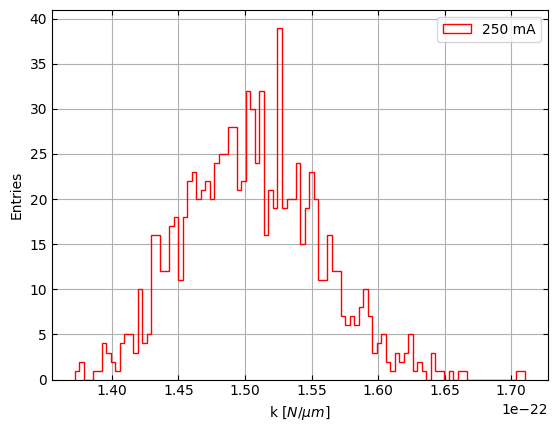

<Figure size 640x480 with 0 Axes>

In [69]:
fig, ax = plt.subplots()

bin_width = 1e-25
#ax.set_yscale('log')
bins = np.arange(min(k_data), max(k_data) + bin_width, bin_width)
ax.set_xlabel(r'k $[N/\mu m]$')
ax.set_ylabel('Entries')
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')

ax.hist(k_data, bins=100, color='white', edgecolor='red', alpha=1, histtype='step', label='250 mA')
ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
plt.legend(loc='upper right')

plt.savefig('equi250.pdf',dpi=100,bbox_inches='tight',format='pdf')
plt.show()
plt.clf()

#fig, ax = plt.subplots()

#bin_width = 0.5
#ax.set_yscale('log')
#bins = np.arange(min(x_strain), max(x_strain) + bin_width, bin_width)
#ax.set_xlabel(r'X Strain $[\mu \text{m}]$')
#ax.set_ylabel('Entries')
#plt.grid(True, which='both', axis='y')
#plt.grid(True, which='both', axis='x')

#ax.hist(x_strain, bins=100, color='white', edgecolor='green', alpha=1, histtype='step', label='80 mA')
#ax.tick_params(axis='both', which='both', direction='in', top=True, right=True)
#plt.legend(loc='upper right')

#plt.savefig('equi80_strainsample.pdf',dpi=100,bbox_inches='tight',format='pdf')
#plt.show()
#plt.clf()

slope: -0.0006422790279676516 +- 0.00034262593777061853
y-int: 1.5850237894922072 +- 0.0568992493266974


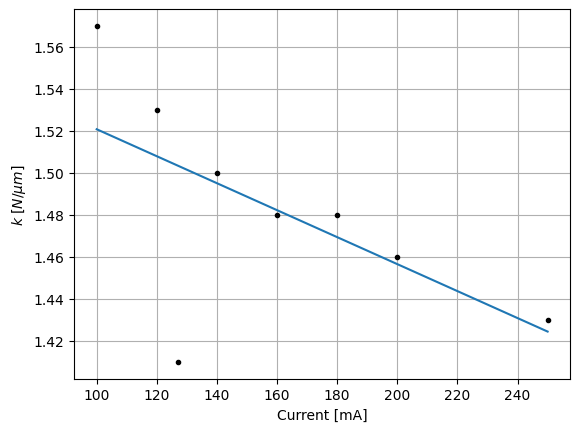

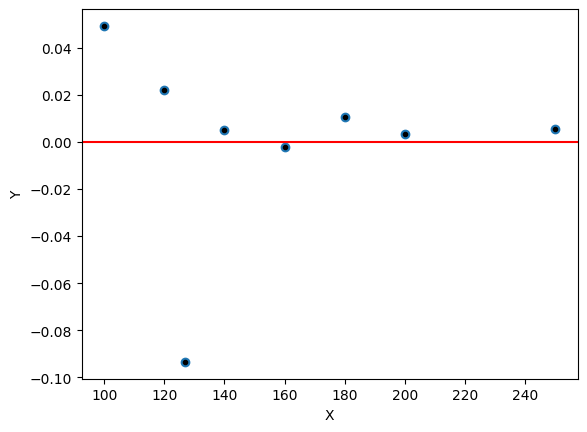

In [133]:
#stiffs_weighed = [3.36, 2.30, 1.57, 1.53, 1.41, 1.50, 1.48, 1.48, 1.46, 1.43]
#stiffs_avg = [2.80, 2.11, 1.61, 1.59, 1.41, 1.54, 1.49, 1.49, 1.48, 1.44]
#currents = [80, 85, 100, 120, 127, 140, 160, 180, 200, 250]

stiffs_weighed = [1.57, 1.53, 1.41, 1.50, 1.48, 1.48, 1.46, 1.43]
stiffs_avg = [1.61, 1.59, 1.41, 1.54, 1.49, 1.49, 1.48, 1.44]
currents = [100, 120, 127, 140, 160, 180, 200, 250]

xdata = np.array(currents)
ydata = np.array(stiffs_weighed)

def func(x,m,b):                                # Define your fitting function

        return m*x+b

initialguess = [1,1]                     # initial guess for the parameters of the function func

fit, covariance = optimize.curve_fit(             # call to the fitting routine curve_fit
        func,                                     # function to fit
        xdata,                                    # data for independant variable
        ydata,                                    # data for dependant variable
        initialguess)                             # initial guess of fit parameter

print("slope:",fit[0],"+-",np.sqrt(covariance[0][0]))     #print value and one std error of the first fit parameter
print("y-int:",fit[1],"+-",np.sqrt(covariance[1][1]))     #print value and one std error of the second fit parameter

##########
# Plotting data and fit
##########

xdatafit=np.linspace(min(xdata), max(xdata), 100)    # make lots of xdata for a smooth curve
func_plot=func(xdatafit,*fit)                # create discrete data set from fitting function

plt.clf()                                    # clear plot figure
plt.plot(xdatafit, func_plot)                # plot the fit function
plt.errorbar(xdata, ydata, fmt='k.')         # plot data with error bars, define format of plot (k=black)
plt.grid(True, which='both', axis='y')
plt.grid(True, which='both', axis='x')
plt.xlabel('Current [mA]',fontsize = 10)           # label x axis
plt.ylabel(r'$k$ $[N/\mu m]$',fontsize = 10)     # label y axis
#plt.xlim(np.min(xdata),np.max(xdata))       # choose limits of x or y axis
#plt.ylim(np.min(ydata),np.max(ydata))       # choose limits of x or y axis
plt.savefig('./k_vs_current.pdf',dpi=100,bbox_inches='tight')
plt.show()                                   # show plot

##########
# Plotting residuals
##########

func_model=func(xdata,*fit)              # create discrete data set from fitting function
residual = (ydata-func_model)            # create array of residual data

plt.clf()
plt.errorbar(xdata, residual, fmt='k.')
plt.plot(xdata, residual, 'o')
plt.axhline(y=0.0, color='r', linestyle='-')
#plt.title('Residual')
plt.xlabel('X',fontsize = 10)
plt.ylabel('Y',fontsize = 10)
plt.savefig('./k_Residual_3.pdf',dpi=100,bbox_inches='tight')
plt.show()